In [1]:
# import packages
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [2]:
# function to check out data 
def dataCheckup(df):
    print('\nData Import Summary:\n')
    # check data types
    print(df.info())
    # line spacing
    print('\n')    

In [3]:
# import data
df = pd.read_csv (r'HW1 clv_transactions.csv')

# data check
dataCheckup(df)

# clean up transaction date to be a pandas date time
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# create year column
df['TransactionYear'] = pd.DatetimeIndex(df['TransactionDate']).year

# create month column
df['TransactionMonth'] = pd.DatetimeIndex(df['TransactionDate']).month

# data check
dataCheckup(df)


Data Import Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    4186 non-null   int64  
 1   TransactionDate  4186 non-null   object 
 2   CustomerID       4186 non-null   int64  
 3   Amount           4186 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 130.9+ KB
None



Data Import Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4186 entries, 0 to 4185
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   TransactionID     4186 non-null   int64         
 1   TransactionDate   4186 non-null   datetime64[ns]
 2   CustomerID        4186 non-null   int64         
 3   Amount            4186 non-null   float64       
 4   TransactionYear   4186 non-null   int64         
 5   TransactionM

# Step 1: Understand the dataset

## 1. Are there any missing values in the dataset?

In [4]:
# use 2 methods to check for missing values
print(df.isnull().any().any())
print(df.isna().values.any())

False
False


## 2. What is the range of dates in the dataset?

In [5]:
print('minimum transaction date: ' + str(df['TransactionDate'].min()))
print('maximum transaction date: ' + str(df['TransactionDate'].max()))
print('range of transactions: ' + str((df['TransactionDate'].max() - df['TransactionDate'].min())))

minimum transaction date: 2010-01-04 00:00:00
maximum transaction date: 2015-12-31 00:00:00
range of transactions: 2187 days 00:00:00


## 3. How many unique customers are there in the dataset?

In [6]:
print('There are ' + str(len(pd.unique(df['CustomerID']))) + ' unique customers in the dataset')

There are 1000 unique customers in the dataset


## 4. Profile the data to give the standard descriptive statistics for the Amount field. What is the min, max, variance, and standard deviations?

In [7]:
print(df.agg({"Amount": ["min","max","var",np.std]}))

          Amount
min    -1.000000
max  2033.000000
var  1499.541111
std    38.723909


## 5. Do transaction amounts in general increase over time (perhaps due to inflation)?


Transaction amounts in total by year tend to increase over time. (Graph 1).


Average transaction amounts increase then decrease over time (Graph 2).



Text(0.5, 1.0, 'Average Dollar Transaction Amount by Year')

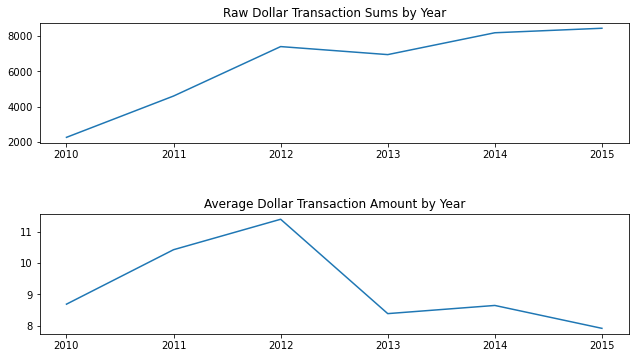

In [8]:
# caculate metrics related to transactions
yearSummary = df.groupby(['TransactionYear'])['Amount'].sum()
countSummary = df.groupby(['TransactionYear'])['TransactionID'].count()
avgTransactionAmount = yearSummary/countSummary

# print response to question
print('\nTransaction amounts in total by year tend to increase over time. (Graph 1).\n')
print('\nAverage transaction amounts increase then decrease over time (Graph 2).\n')

# plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
fig.tight_layout(pad=5.0)
ax1.plot(yearSummary)
ax1.set_title('Raw Dollar Transaction Sums by Year')
ax2.plot(avgTransactionAmount)
ax2.set_title('Average Dollar Transaction Amount by Year')

# Step 2: Explore the dataset

## 1. Are there any outliers?

In [9]:
print('Yes, there are outliers. See the plots below')

Yes, there are outliers. See the plots below


[]

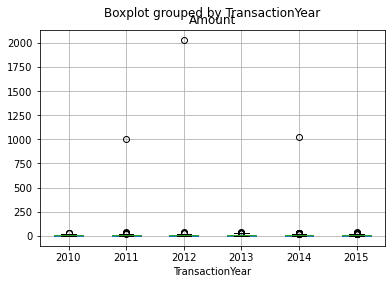

In [10]:
# step 2.1.1: plot a boxplot
boxplot = df.loc[:,['TransactionYear','Amount']].boxplot(column='Amount', by = 'TransactionYear')
boxplot.plot()

Text(0.5, 1.0, 'Histogram of Amount')

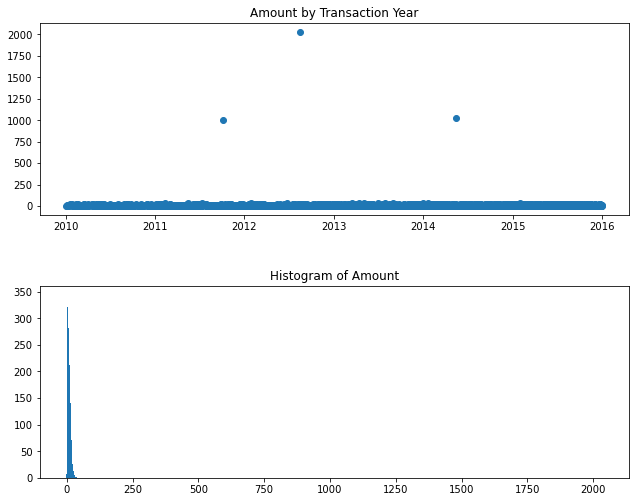

In [11]:
# step 2.1.2: plot a scatter plot and histogram of the data

# plot data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
fig.tight_layout(pad=5.0)
ax1.scatter(y = df['Amount'], x = df['TransactionDate'])
ax1.set_title('Amount by Transaction Year')
ax2.hist(df['Amount'], bins='auto')
ax2.set_title('Histogram of Amount')

In [12]:
# step 2.1.4: describe the dataframe
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TransactionID,4186.0,2093.500000,1208.538442,1.0,1047.25,2093.500,3139.75,4186.0
CustomerID,4186.0,516.165791,291.465283,1.0,270.00,522.000,762.75,1000.0
Amount,4186.0,9.028082,38.723909,-1.0,3.31,6.885,11.69,2033.0
TransactionYear,4186.0,2013.182035,1.531454,2010.0,2012.00,2013.000,2015.00,2015.0
TransactionMonth,4186.0,6.687530,3.447898,1.0,4.00,7.000,10.00,12.0


## 2. If so how would you treat them?

### Based on the analysis conducted above, we know there are some outlier values for the dataset. The transactions which are -1 are most likely outliers, so are the high dollar amount purchases. 
#### There are 2 ways in which I tried to treat outliers, using the 90th and 10th percentiles and then imputing the median. I also tried to use isolation forest. 
#### Method 1: For the 90th and 10th percentiles I analyzed the data by the raw median and then median by customer id. I opted to use the raw median as this eliminated some noise. 
#### Method 2: For isolation forest, I set the conamination factor low so that most of the data was preserved. The 0.03 factor preserves 97% of the data, eliminates the -1 values, and the large amount values. Scatter plots below show the result of the cleaning. 
#### Ultimately, I selected isolation forest as my method of treating outliers as this is a scaleable solution and used frequently in anomaly detection.

In [13]:
# get median value of amount 

trueMedian = df['Amount'].median()

print(trueMedian)

6.885


In [14]:
### METHOD 1

# get the median amount per customer in the dataframe, this will be used for substitution if illogial values occur
CustMedianAmount = df.groupby(['CustomerID'])['Amount'].median().to_frame(name = 'CustMedianAmount').reset_index()

# merge median dataframe back to the regular dataframe
df = df.merge(CustMedianAmount, on='CustomerID', how = 'left') 

# replace all values above the 90th percentile or lower than the 10th percentile with the median for that customer
df['CleanAmountPercentile'] = np.where(((df['Amount'] > df['Amount'].quantile(.9)) | (df['Amount'] < df['Amount'].quantile(.1))), df['CustMedianAmount'], df['Amount'])

In [15]:
### METHOD 2

### source: https://www.analyticsvidhya.com/blog/2021/04/dealing-with-anomalies-in-the-data/
# use isolation forest to handle anomalies
isolation_forest = IsolationForest(contamination=0.03) # DID NOT USE AUTO CONTAMINATION FACTOR
isolation_forest.fit(df['Amount'].values.reshape(-1, 1))
df['anomaly_score_rate'] = isolation_forest.decision_function(df['Amount'].values.reshape(-1, 1))
df['outlier_univariate_rate'] = isolation_forest.predict(df['Amount'].values.reshape(-1, 1))

# replace all values identified as outliers by the isolation forest for data modeling
df['CleanAmount'] = np.where(df['outlier_univariate_rate'] == -1, trueMedian, df['Amount'])

[]

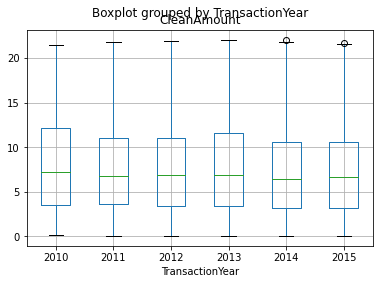

In [16]:
# inspect boxplot to make ensure data looks more reasonable than in step 2.1
boxplot = df.loc[:,['TransactionYear','CleanAmount']].boxplot(column='CleanAmount', by = 'TransactionYear')
boxplot.plot()

Text(0.5, 1.0, 'Clean Histogram of Amount')

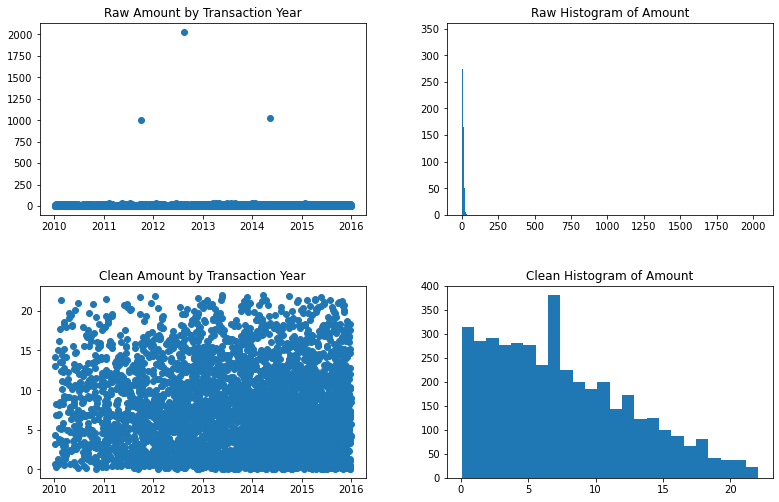

In [17]:
# compare plots between raw and clean transaction amounts
# spike in clean historgram is from imputing the median value

fig, axs = plt.subplots(2,2, figsize=(12, 8))
fig.tight_layout(pad=5.0)

# raw amount scatter plot
axs[0,0].scatter(y = df['Amount'], x = df['TransactionDate'])
axs[0,0].set_title('Raw Amount by Transaction Year')

# raw amount histogram
axs[0,1].hist(df['Amount'], bins='auto')
axs[0,1].set_title('Raw Histogram of Amount')

# clean amount scatter plot
axs[1,0].scatter(y = df['CleanAmount'], x = df['TransactionDate'])
axs[1,0].set_title('Clean Amount by Transaction Year')

# clean amount histogram
axs[1,1].hist(df['CleanAmount'], bins='auto')
axs[1,1].set_title('Clean Histogram of Amount')

In [18]:
# re-inspect the describe the dataframe function
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TransactionID,4186.0,2093.500000,1208.538442,1.000000,1047.250000,2093.500000,3139.750000,4186.000000
CustomerID,4186.0,516.165791,291.465283,1.000000,270.000000,522.000000,762.750000,1000.000000
Amount,4186.0,9.028082,38.723909,-1.000000,3.310000,6.885000,11.690000,2033.000000
TransactionYear,4186.0,2013.182035,1.531454,2010.000000,2012.000000,2013.000000,2015.000000,2015.000000
TransactionMonth,4186.0,6.687530,3.447898,1.000000,4.000000,7.000000,10.000000,12.000000
CustMedianAmount,4186.0,7.384670,3.339420,0.010000,5.115000,7.005000,9.095000,25.170000
CleanAmountPercentile,4186.0,7.509202,4.176795,0.010000,4.142500,6.930000,10.450000,25.170000
anomaly_score_rate,4186.0,0.124756,0.049696,-0.204112,0.107304,0.143445,0.153613,0.177592
outlier_univariate_rate,4186.0,0.940277,0.340451,-1.000000,1.000000,1.000000,1.000000,1.000000
CleanAmount,4186.0,7.564110,5.193328,0.050000,3.320000,6.885000,11.010000,22.050000


# Step 3: Determine origin year of customers

In [19]:
# determining the earliest transaction year for a customer
CustOrigin = df.groupby(['CustomerID'])['TransactionYear'].min().to_frame(name = 'CustOrigin').reset_index()

# merge the dataframe back to the 'main' data frame
df = df.merge(CustOrigin, on='CustomerID', how = 'left')

In [20]:
# create column that is formatted for printing
df['CustOriginRange'] = df['CustOrigin']

# clean up naming of dataframe origin to match professor through dictionary re-map 
overRideYearDict = { 
    2010:'2010-01-01 - 2010-12-31',
    2011:'2011-01-01 - 2011-12-31',
    2012:'2012-01-01 - 2012-12-31',
    2013:'2013-01-01 - 2013-12-31',
    2014:'2014-01-01 - 2014-12-31',
    2015:'2015-01-01 - 2015-12-31'
  }

# create dataframe from dictionary remap
overRideYear = pd.DataFrame(overRideYearDict.items(),columns=['old','new'])

# update the dataframe so that the values are overridden in place
for old,new in overRideYear.values:
    df.loc[df['CustOriginRange'] == old, 'CustOriginRange']=new

In [21]:
# determine which age bucket that the transaction falls into for each customer
# minimum bucket is 12 based on professors handout
df['CustOriginMonths'] = ((df['TransactionYear'] - df['CustOrigin']) * 12) + 12

In [22]:
# create unique key based on origin year and origin months
df['CustomerOriginKey'] = df['CustOrigin'].astype(str) + df['CustOriginMonths'].astype(str)

In [23]:
# print result
df.head()

,TransactionID,TransactionDate,CustomerID,Amount,TransactionYear,TransactionMonth,CustMedianAmount,CleanAmountPercentile,anomaly_score_rate,outlier_univariate_rate,CleanAmount,CustOrigin,CustOriginRange,CustOriginMonths,CustomerOriginKey
0,1,2012-09-04,1,20.26,2012,9,20.260,20.26,0.017499,1,20.26,2012,2012-01-01 - 2012-12-31,12,201212
1,2,2012-05-15,2,10.87,2012,5,3.725,10.87,0.152232,1,10.87,2012,2012-01-01 - 2012-12-31,12,201212
2,3,2014-05-23,2,2.21,2014,5,3.725,2.21,0.134821,1,2.21,2012,2012-01-01 - 2012-12-31,36,201236
3,4,2014-10-24,2,10.48,2014,10,3.725,10.48,0.151273,1,10.48,2012,2012-01-01 - 2012-12-31,36,201236
4,5,2012-10-13,2,3.94,2012,10,3.725,3.94,0.161144,1,3.94,2012,2012-01-01 - 2012-12-31,12,201212


# Step 4: Calculate cumulative transaction amounts

## First, find the transaction records for customers with the origin year 2010 (use your result from step 3)

In [24]:
df.loc[df['CustOrigin'] == 2010]

,TransactionID,TransactionDate,CustomerID,Amount,TransactionYear,TransactionMonth,CustMedianAmount,CleanAmountPercentile,anomaly_score_rate,outlier_univariate_rate,CleanAmount,CustOrigin,CustOriginRange,CustOriginMonths,CustomerOriginKey
28,29,2010-02-04,9,0.74,2010,2,9.725,9.725,0.106721,1,0.74,2010,2010-01-01 - 2010-12-31,12,201012
29,30,2014-05-23,9,11.87,2014,5,9.725,11.870,0.131410,1,11.87,2010,2010-01-01 - 2010-12-31,60,201060
30,31,2010-12-06,9,15.50,2010,12,9.725,15.500,0.093850,1,15.50,2010,2010-01-01 - 2010-12-31,12,201012
31,32,2011-09-14,9,11.46,2011,9,9.725,11.460,0.134539,1,11.46,2010,2010-01-01 - 2010-12-31,24,201024
32,33,2014-07-12,9,7.99,2014,7,9.725,7.990,0.152364,1,7.99,2010,2010-01-01 - 2010-12-31,60,201060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,4182,2013-06-23,1000,3.86,2013,6,5.465,3.860,0.159346,1,3.86,2010,2010-01-01 - 2010-12-31,48,201048
4182,4183,2011-08-07,1000,4.00,2011,8,5.465,4.000,0.164901,1,4.00,2010,2010-01-01 - 2010-12-31,24,201024
4183,4184,2012-10-07,1000,18.37,2012,10,5.465,5.465,0.061223,1,18.37,2010,2010-01-01 - 2010-12-31,36,201036
4184,4185,2014-01-09,1000,3.45,2014,1,5.465,3.450,0.149583,1,3.45,2010,2010-01-01 - 2010-12-31,60,201060


## Then, sum up the amounts made by these customers up to 12 months later than the origin year. Therefore, you should check the TransactionDate to determine if you should include a particular transaction into the sum (e.g. you sum the amount only if the TransactionDate is no greater than 12 months since the start of 2010). Now, do the same calculations for the rest of the entries in the table and print your table to standard output (or document it in comments block). Note: you may not get the same numbers as those in the example table above.

In [25]:
# https://stackoverflow.com/questions/22650833/pandas-groupby-cumulative-sum
# group data by sum, then do another grouping based on cum sum and drop the indexing from the group by
amountdf = df.groupby(['CustOriginRange','CustOrigin','CustOriginMonths', 'CustomerOriginKey'])['CleanAmount'].sum().groupby(level=0).cumsum().reset_index()

# set the key to be int64, important for subsequent merge operations
amountdf['CustomerOriginKey'] = amountdf['CustomerOriginKey'].astype(str).astype(int)

In [26]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html

# print out a pivot table based on the amountdf created above
amounttable = pd.pivot_table(amountdf, values=('CleanAmount'), index=['CustOriginRange'],columns='CustOriginMonths',aggfunc=np.sum, fill_value=' ')

# print the table
amounttable

CustOriginMonths,12,24,36,48,60,72
CustOriginRange,,,,,,
2010-01-01 - 2010-12-31,2123.655,3403.585,4948.755,6235.3,7485.445,8465.97
2011-01-01 - 2011-12-31,2044.515,3510.785,5095.65,6276.765,7369.64,
2012-01-01 - 2012-12-31,2025.550,3589.385,4829.835,6046.47,,
2013-01-01 - 2013-12-31,2060.520,3441.41,4947.625,,,
2014-01-01 - 2014-12-31,1768.255,3108.18,,,,
2015-01-01 - 2015-12-31,1725.480,,,,,


# Step 5: Calculate cumulative customer amounts

In [27]:
# get unique count of customer id by customer origin year
newcustomerunique = df.groupby(['CustOriginRange'])['CustomerID'].nunique().to_frame(name = 'UniqueCustomers').reset_index()
newcustomerunique

,CustOriginRange,UniqueCustomers
0,2010-01-01 - 2010-12-31,172
1,2011-01-01 - 2011-12-31,171
2,2012-01-01 - 2012-12-31,162
3,2013-01-01 - 2013-12-31,180
4,2014-01-01 - 2014-12-31,155
5,2015-01-01 - 2015-12-31,160


In [28]:
# get dataframe with unique: 
    #CustOriginPrinting
    #CustOriginMonths
    #CustomerOriginKey

# then merge the unique customers from above
newcustomer = df.drop_duplicates(['CustOriginRange','CustOrigin','CustOriginMonths', 'CustomerOriginKey'])[['CustOriginRange','CustOriginMonths', 'CustomerOriginKey']]
newcustomer = newcustomer.merge(newcustomerunique, on = 'CustOriginRange', how='left')

# set the key to be int64, important for subsequent merge operations
newcustomer['CustomerOriginKey'] = newcustomer['CustomerOriginKey'].astype(str).astype(int)

In [29]:
# print out a pivot table based on the new customer data frame
newcustomertable = pd.pivot_table(newcustomer, values=('UniqueCustomers'), index=['CustOriginRange'],columns='CustOriginMonths',aggfunc=np.sum, fill_value=' ')

# print the table
newcustomertable

CustOriginMonths,12,24,36,48,60,72
CustOriginRange,,,,,,
2010-01-01 - 2010-12-31,172.0,172.0,172.0,172.0,172.0,172.0
2011-01-01 - 2011-12-31,171.0,171.0,171.0,171.0,171.0,
2012-01-01 - 2012-12-31,162.0,162.0,162.0,162.0,,
2013-01-01 - 2013-12-31,180.0,180.0,180.0,,,
2014-01-01 - 2014-12-31,155.0,155.0,,,,
2015-01-01 - 2015-12-31,160.0,,,,,


# Step 6: Historic CLV

In [30]:
# get merged dataframe of the amount and transaction records so that division operation can occur
# https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns
historicalCLV = amountdf.merge(newcustomer, on = 'CustomerOriginKey', how = 'left', suffixes=('','_y'))
historicalCLV.drop(historicalCLV.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

In [31]:
# basic concept is to divide amount by new customers row over row
historicalCLV['HistoricalCLV'] = historicalCLV['CleanAmount'] / historicalCLV['UniqueCustomers'] 
historicalCLV.head()

,CustOriginRange,CustOrigin,CustOriginMonths,CustomerOriginKey,CleanAmount,UniqueCustomers,HistoricalCLV
0,2010-01-01 - 2010-12-31,2010,12,201012,2123.655,172,12.346831
1,2010-01-01 - 2010-12-31,2010,24,201024,3403.585,172,19.788285
2,2010-01-01 - 2010-12-31,2010,36,201036,4948.755,172,28.771831
3,2010-01-01 - 2010-12-31,2010,48,201048,6235.300,172,36.251744
4,2010-01-01 - 2010-12-31,2010,60,201060,7485.445,172,43.520029


In [32]:
# get dataframe of customer origin months to act as a weight for each row of the dataframe
volumeWeight = historicalCLV.groupby(['CustOriginMonths'])['UniqueCustomers'].sum().to_frame(name = 'VolumeWeight').reset_index()

# merge dataframes together
historicalCLV = historicalCLV.merge(volumeWeight, on = 'CustOriginMonths', how = 'left', suffixes=('','_y'))
historicalCLV.drop(historicalCLV.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)

# create volume weighted CLV
historicalCLV['VolumeWeightedCLVAtMonth'] = historicalCLV['HistoricalCLV'] * (historicalCLV['UniqueCustomers'] / historicalCLV['VolumeWeight'])

historicalCLV.head()

,CustOriginRange,CustOrigin,CustOriginMonths,CustomerOriginKey,CleanAmount,UniqueCustomers,HistoricalCLV,VolumeWeight,VolumeWeightedCLVAtMonth
0,2010-01-01 - 2010-12-31,2010,12,201012,2123.655,172,12.346831,1000,2.123655
1,2010-01-01 - 2010-12-31,2010,24,201024,3403.585,172,19.788285,840,4.051887
2,2010-01-01 - 2010-12-31,2010,36,201036,4948.755,172,28.771831,685,7.224460
3,2010-01-01 - 2010-12-31,2010,48,201048,6235.300,172,36.251744,505,12.347129
4,2010-01-01 - 2010-12-31,2010,60,201060,7485.445,172,43.520029,343,21.823455


In [33]:
# print out a pivot table based on the CLV table
historicalCLVTable = pd.pivot_table(historicalCLV, values=('HistoricalCLV'), index=['CustOriginRange'],columns='CustOriginMonths',aggfunc=np.sum, fill_value=' ')

# print the table
historicalCLVTable

CustOriginMonths,12,24,36,48,60,72
CustOriginRange,,,,,,
2010-01-01 - 2010-12-31,12.346831,19.788285,28.771831,36.251744,43.520029,49.220756
2011-01-01 - 2011-12-31,11.956228,20.530906,29.799123,36.706228,43.09731,
2012-01-01 - 2012-12-31,12.503395,22.156698,29.813796,37.323889,,
2013-01-01 - 2013-12-31,11.447333,19.118944,27.486806,,,
2014-01-01 - 2014-12-31,11.408097,20.052774,,,,
2015-01-01 - 2015-12-31,10.784250,,,,,


<AxesSubplot:title={'center':'Historic CLV'}, xlabel='CustOriginMonths'>

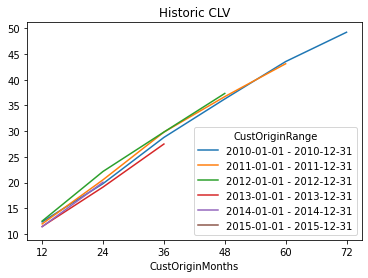

In [34]:
# print out a pivot table based on the amountdf created above
printTable = pd.pivot_table(historicalCLV, values=('HistoricalCLV'), index=['CustOriginMonths'],columns='CustOriginRange')
printTable.plot(xticks = printTable.index, title = 'Historic CLV')

      CustOriginMonths    weightedCLV
--  ------------------  -------------
 0                  12        11.748
 1                  24        20.3016
 2                  36        28.937
 3                  48        36.7496
 4                  60        43.3093
 5                  72        49.2208


<AxesSubplot:title={'center':'Weighted CLV'}, xlabel='CustOriginMonths'>

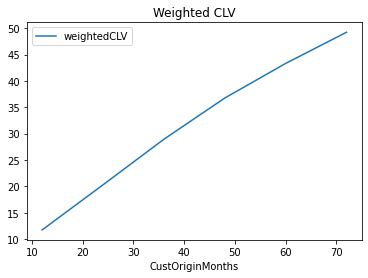

In [35]:
# get table of estimated weighted CLV
weightedCLV = historicalCLV.groupby(['CustOriginMonths'])['VolumeWeightedCLVAtMonth'].sum().to_frame(name = 'weightedCLV').reset_index()
print(tabulate(weightedCLV, headers=["CustOriginMonths", "weightedCLV"]))

# plot the weighted CLV in totality
weightedCLV = weightedCLV.set_index('CustOriginMonths')
weightedCLV.plot(title = 'Weighted CLV')

# Step 7: Interpreting your results

## How much have customers acquired in 2011 spent to date?

In [36]:
print('customers acquired in 2011 spent about 7.3K to date')

amounttable

customers acquired in 2011 spent about 7.3K to date


CustOriginMonths,12,24,36,48,60,72
CustOriginRange,,,,,,
2010-01-01 - 2010-12-31,2123.655,3403.585,4948.755,6235.3,7485.445,8465.97
2011-01-01 - 2011-12-31,2044.515,3510.785,5095.65,6276.765,7369.64,
2012-01-01 - 2012-12-31,2025.550,3589.385,4829.835,6046.47,,
2013-01-01 - 2013-12-31,2060.520,3441.41,4947.625,,,
2014-01-01 - 2014-12-31,1768.255,3108.18,,,,
2015-01-01 - 2015-12-31,1725.480,,,,,


In [37]:
print('\nif we''re looking at the the weighted CLV for customers acquired in 2011, their spend is about $43')
historicalCLVTable


if were looking at the the weighted CLV for customers acquired in 2011, their spend is about $43


CustOriginMonths,12,24,36,48,60,72
CustOriginRange,,,,,,
2010-01-01 - 2010-12-31,12.346831,19.788285,28.771831,36.251744,43.520029,49.220756
2011-01-01 - 2011-12-31,11.956228,20.530906,29.799123,36.706228,43.09731,
2012-01-01 - 2012-12-31,12.503395,22.156698,29.813796,37.323889,,
2013-01-01 - 2013-12-31,11.447333,19.118944,27.486806,,,
2014-01-01 - 2014-12-31,11.408097,20.052774,,,,
2015-01-01 - 2015-12-31,10.784250,,,,,


## Do each group of customers exhibit similar or different patterns of spending? What’s the implication for the business?

In [38]:
print('If we were to perform statistical tests for differences amount groups at different annual buckets, the data would most likely indicate that there aren''t differences in groups.\n')
print('This means that we can expect new customers to have similar top line revenue into the future. Analysts can use historical trends to forecast into the future with reasonable accuracy, all else equal\n')
print('One callout is that for the 12 months category, there is a decrease in historic CLV, evidenced by the decrease for $12 to $10')

historicalCLVTable

If we were to perform statistical tests for differences amount groups at different annual buckets, the data would most likely indicate that there arent differences in groups.

This means that we can expect new customers to have similar top line revenue into the future. Analysts can use historical trends to forecast into the future with reasonable accuracy, all else equal

One callout is that for the 12 months category, there is a decrease in historic CLV, evidenced by the decrease for $12 to $10


CustOriginMonths,12,24,36,48,60,72
CustOriginRange,,,,,,
2010-01-01 - 2010-12-31,12.346831,19.788285,28.771831,36.251744,43.520029,49.220756
2011-01-01 - 2011-12-31,11.956228,20.530906,29.799123,36.706228,43.09731,
2012-01-01 - 2012-12-31,12.503395,22.156698,29.813796,37.323889,,
2013-01-01 - 2013-12-31,11.447333,19.118944,27.486806,,,
2014-01-01 - 2014-12-31,11.408097,20.052774,,,,
2015-01-01 - 2015-12-31,10.784250,,,,,
